# Lab3. Graph Convolutional Network

In [1]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import torch
import numpy as np

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#вспомогательная функция для визуализации
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

Processing...
Done!


In [4]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6


In [5]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [6]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels1, hidden_channels2):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

model1 = GCN(hidden_channels1 = 32, hidden_channels2 = 16)
model1.eval()
print(model1)

GCN(
  (conv1): GCNConv(3703, 32)
  (conv2): GCNConv(32, 16)
  (conv3): GCNConv(16, 6)
)


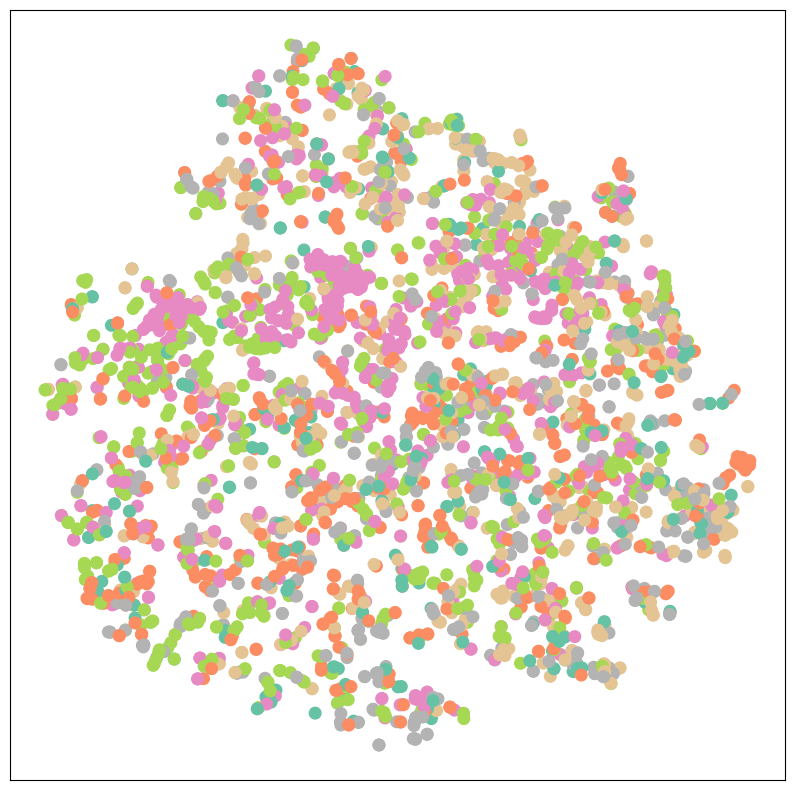

In [7]:
output = model1(data.x, data.edge_index)
visualize(output, color=data.y)

In [8]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

#функции train, validate и test
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

#валидация
def validate():
  model.eval()
  out = model(data.x, data.edge_index)
  val_pred = out.argmax(dim=1)  # Use the class with highest probability.
  test_correct = val_pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
  test_accuracy = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
  return test_accuracy

def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)  # Use the class with highest probability.
  test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
  test_accuracy = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
  return test_accuracy


<IPython.core.display.Javascript object>

In [9]:
#параметры для перебора
lrs = [0.1, 0.01, 0.001]
weight_decays = [5e-3, 5e-4, 5e-5]
criterion = torch.nn.CrossEntropyLoss()

for lr in lrs:
  for weight_decay in weight_decays:
    model = GCN(hidden_channels1 = 32, hidden_channels2 = 16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
    for epoch in range(1, 101):
      loss = train()
    val_acc = validate()
    print(f'lr: {lr}, weight_decay: {weight_decay}, Accuracy: {val_acc:.4f}')

lr: 0.1, weight_decay: 0.005, Accuracy: 0.6080
lr: 0.1, weight_decay: 0.0005, Accuracy: 0.6340
lr: 0.1, weight_decay: 5e-05, Accuracy: 0.6460
lr: 0.01, weight_decay: 0.005, Accuracy: 0.6360
lr: 0.01, weight_decay: 0.0005, Accuracy: 0.6500
lr: 0.01, weight_decay: 5e-05, Accuracy: 0.6700
lr: 0.001, weight_decay: 0.005, Accuracy: 0.6660
lr: 0.001, weight_decay: 0.0005, Accuracy: 0.6620
lr: 0.001, weight_decay: 5e-05, Accuracy: 0.6440


лучшие параметры:

lr: 0.01, weight_decay: 5e-05, Accuracy: 0.6660

In [10]:

model = GCN(hidden_channels1 = 32, hidden_channels2 = 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
for epoch in range(1, 201):
  loss = train()
  if epoch % 20 == 0:
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 020, Loss: 1.3369
Epoch: 040, Loss: 0.5616
Epoch: 060, Loss: 0.2617
Epoch: 080, Loss: 0.1798
Epoch: 100, Loss: 0.1203
Epoch: 120, Loss: 0.1063
Epoch: 140, Loss: 0.1174
Epoch: 160, Loss: 0.0738
Epoch: 180, Loss: 0.0951
Epoch: 200, Loss: 0.0932
Test Accuracy: 0.6400


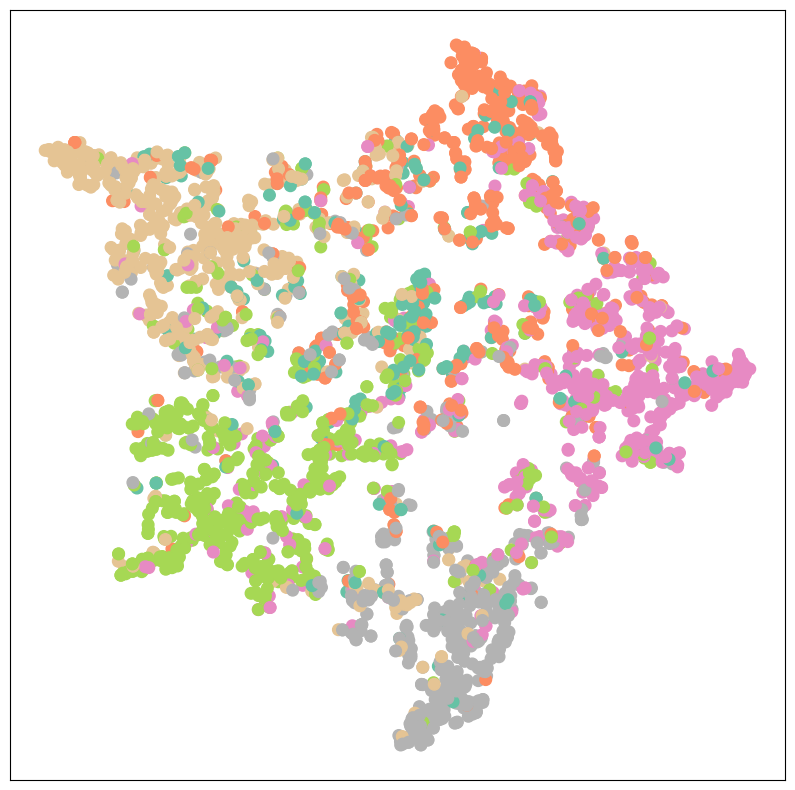

In [11]:
model.eval()

output = model(data.x, data.edge_index)
visualize(output, color=data.y)

По результатам, классификация отображается в виде звезды в зависимости от классов, но при этом очень много объектов пересекаются в центре и заходят на смежные концы зведы (классы)

# Реализация собственного слоя GCN

In [12]:
# Функция для вычисления категориальной кросс-энтропии.
def cross_entropy_loss(target, predictions, epsilon=1e-8):
    # Добавляю малую величину epsilon для избежания деления на 0
    return -np.mean(np.sum(target * np.log(predictions + epsilon), axis=1))

# Вычисление матрицы степеней для вершин графа.
def calculate_degree_matrix(adj_matrix):
    # Суммирую веса рёбер для каждой вершины, чтобы построить матрицу степеней
    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    return degree_matrix

# Функция для вычисления нормализованного лапласиана графа: L = I - D^(-1/2)AD^(-1/2).
# Для ускорения можно использовать приближение через многочлены Чебышева.
def normalized_graph_laplacian(adj_matrix):
    degree_matrix = calculate_degree_matrix(adj_matrix)
    sqrt_degree = np.sqrt(degree_matrix)
    # Использую псевдообратную матрицу (pinv), так как матрица может быть сингулярной
    inv_sqrt_degree = np.linalg.pinv(sqrt_degree)
    identity_matrix = np.identity(len(adj_matrix))
    # Вычисляю лапласиан по формуле
    return identity_matrix - np.dot(inv_sqrt_degree, np.dot(adj_matrix, inv_sqrt_degree))

# Реализация функций активации: ReLU и Softmax.
def relu_activation(data):
    # Обнуляю все отрицательные значения
    return data * (data > 0)

def softmax_activation(data):
    # Вычисляю экспоненты с нормализацией
    exp_data = np.exp(data - np.max(data, axis=-1, keepdims=True))
    return exp_data / np.sum(exp_data, axis=-1, keepdims=True)

# Класс для реализации слоя графовой сверточной сети (Graph Convolutional Network, GCN).
class GraphConvLayer:
    # Конструктор для инициализации параметров слоя
    def __init__(self, input_dim, output_dim):
        # Инициализирую случайную матрицу весов
        self.weights = np.random.randn(input_dim, output_dim)
        # Инициализирую смещения нулями
        self.bias = np.zeros((1, output_dim))
        # Храню матрицы данных и смежности, которые понадобятся при обучении
        self.adj_matrix, self.node_features = None, None

    # Прямой проход через слой
    def forward(self, features, adj_matrix):
        # Сохраняю входные данные для обратного прохода
        self.node_features = features
        self.adj_matrix = adj_matrix
        # Вычисляю лапласиан графа
        laplacian = normalized_graph_laplacian(self.adj_matrix)
        # Возвращаю преобразованные признаки с применением весов и смещений
        return np.dot(np.dot(laplacian, self.node_features), self.weights) + self.bias

    # Обратный проход для обновления параметров слоя
    def backward(self, error, learning_rate):
        laplacian = normalized_graph_laplacian(self.adj_matrix)
        # Градиент по весам
        feature_contrib = np.dot(self.node_features.T, laplacian)
        grad_weights = np.dot(feature_contrib, error)
        # Градиент по смещениям
        grad_bias = np.sum(error, axis=0, keepdims=True)
        # Обновляю параметры слоя
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias
        # Возвращаю градиент для предыдущего слоя
        return np.dot(laplacian.T, np.dot(error, self.weights.T))


In [13]:
import torch.nn.functional as F

# Класс для построения многослойной графовой сверточной сети (GCN).
class GraphNetwork:
    # Конструктор сети
    def __init__(self, hidden_dim1, hidden_dim2):
        # Создаю три сверточных слоя с заданными размерами
        self.layer1 = GraphConvLayer(dataset.num_features, hidden_dim1)  # Первый слой
        self.layer2 = GraphConvLayer(hidden_dim1, hidden_dim2)           # Второй слой
        self.layer3 = GraphConvLayer(hidden_dim2, dataset.num_classes)   # Третий слой

    # Прямой проход через сеть
    def forward_pass(self, features, adj_matrix):
        # Первый сверточный слой с активацией ReLU
        features = self.layer1.forward(features, adj_matrix)
        features = relu_activation(features)

        # Второй сверточный слой с активацией ReLU
        features = self.layer2.forward(features, adj_matrix)
        features = relu_activation(features)

        # Третий сверточный слой с функцией Softmax
        features = self.layer3.forward(features, adj_matrix)
        return softmax_activation(features)

    # Обратный проход для вычисления градиентов и обновления параметров
    def backward_pass(self, target, predictions, learning_rate=0.01):
        error = (predictions - target) / target.shape[0]

        grad_layer3 = self.layer3.backward(error, learning_rate)
        grad_layer2 = self.layer2.backward(grad_layer3, learning_rate)
        grad_layer1 = self.layer1.backward(grad_layer2, learning_rate)

        return grad_layer1, grad_layer2, grad_layer3


In [14]:
# Подготовка данных для модели
# Создаю матрицу смежности
adjacency_matrix = np.zeros((data.num_nodes, data.num_nodes))  # Инициализирую пустую матрицу

# Перенос информации о рёбрах в матрицу смежности
edge_indices = data.edge_index.numpy()
adjacency_matrix[edge_indices[0], edge_indices[1]] = 1  # Добавляю направленные рёбра
adjacency_matrix[edge_indices[1], edge_indices[0]] = 1  # Добавляю обратные рёбра

# Обозначаю матрицу смежности как `adj_matrix`
adj_matrix = adjacency_matrix
labels = data.y.numpy()
num_classes = len(np.unique(labels))

# Преобразую метки в формат one-hot (каждая метка представлена вектором с одним активным элементом)
one_hot_labels = np.eye(num_classes)[labels]

In [21]:
# Создание экземпляра графовой нейронной сети
gcn_model = GraphNetwork(hidden_dim1=16, hidden_dim2=16)  # Указываю количество скрытых нейронов в слоях

# Итерации обучения
for iteration in range(1, 21):
    predictions = gcn_model.forward_pass(data.x, adj_matrix)
    current_loss = cross_entropy_loss(one_hot_labels[data.train_mask], predictions[data.train_mask])
    print(f'Epoh: {iteration}, loss: {current_loss}')

    gcn_model.backward_pass(one_hot_labels, predictions, learning_rate=0.1)

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')


Epoh: 1, loss: 3.1216447933572526
Epoh: 2, loss: 2.9537029564681925
Epoh: 3, loss: 2.8443821990682094
Epoh: 4, loss: 2.7652260648112956
Epoh: 5, loss: 2.705297751466899
Epoh: 6, loss: 2.6548714038216548
Epoh: 7, loss: 2.609484710492053
Epoh: 8, loss: 2.568945492713153
Epoh: 9, loss: 2.5323294173267867
Epoh: 10, loss: 2.5004280890198176
Epoh: 11, loss: 2.4728176504275132
Epoh: 12, loss: 2.4483003824835814
Epoh: 13, loss: 2.4259973526522645
Epoh: 14, loss: 2.405414031693236
Epoh: 15, loss: 2.386230105129185
Epoh: 16, loss: 2.368580225077749
Epoh: 17, loss: 2.3520144719957803
Epoh: 18, loss: 2.3361613719858316
Epoh: 19, loss: 2.3212622909262186
Epoh: 20, loss: 2.3072393379816094
Test Accuracy: 0.6400
